In [1]:
VARIANT_NUM = 26

# LSTM Model

#### Goal of This File:

##### 1. Import Libraries, Helper Functions, and Constants ==> Data Sourcing and Munging ==> Utility Functions ==> Loading the Data ==> Merging all Individual Files

##### 2. Imbalanced Data Solution ==> Class Weights ==> Glove + Hyperparameters

##### 3. Bidirectional LSTM

##### 4. Conclusion ==> Results ==> Tensorboard

## 1. Import Libraries, Helper Functions and Load Constants

In [2]:
!pip install pandas numpy nltk scikit-learn wordcloud\
seaborn gensim tensorflow imblearn xgboost matplotlib unrar pyunpack more-itertools patool transformers > /dev/null


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
VAST = True

if VAST:
    !sudo apt-get install unrar
    !sudo apt-get install rar
    
GDRIVE = True

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 61 not upgraded.
Need to get 113 kB of archives.
After this operation, 406 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 unrar amd64 1:5.6.6-2build1 [113 kB]
Fetched 113 kB in 0s (304 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unrar.
(Reading database ... 21887 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a5.6.6-2build1_amd64.deb ...
Unpacking unrar (1:5.6.6-2build1) ...
Setting up unrar (1:5.6.6-2build1) ...
update-alternatives: using /usr/bin/unrar-nonfree to provide /usr/bin/unrar (unrar) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/unrar.1.gz because associated file /usr/share/man/man1/unra

In [4]:
UTILS_URL = 'https://f005.backblazeb2.com/file/gp-support-files/nlp_ai_utils.py'
UPDATING_VALUES_URL = 'https://f005.backblazeb2.com/file/gp-support-files/updating_values.py'
ALL_LIBS_URL = 'https://f005.backblazeb2.com/file/gp-support-files/all_libs_dl.py'
CHUNKS_URLS_FILE_URL = 'https://f005.backblazeb2.com/file/gp-support-files/chunks_urls.py'

UTILS_FILE_NAME = 'nlp_ai_utils'
UPDATING_VALUES_FILE_NAME = 'updating_values'
ALL_LIBS_FILE_NAME = 'all_libs_dl'
CHUNKS_URLS_FILE_NAME = 'chunks_urls'

DEP_FILE_EXT = '.py'

In [5]:
import requests
import os

def get_dependencies(url,file_name,file_extension):
    if os.path.exists(file_name + file_extension):
        return print(file_name + " already exists.")
    else:
        print(f"downloading {file_name}...")
        r = requests.get(url)
        with open(file_name + file_extension, 'wb') as fd:
            for chunk in r.iter_content():
                fd.write(chunk)

In [6]:
get_dependencies(UTILS_URL,UTILS_FILE_NAME,DEP_FILE_EXT)
get_dependencies(UPDATING_VALUES_URL,UPDATING_VALUES_FILE_NAME,DEP_FILE_EXT)
get_dependencies(ALL_LIBS_URL,ALL_LIBS_FILE_NAME,DEP_FILE_EXT)
get_dependencies(CHUNKS_URLS_FILE_URL,CHUNKS_URLS_FILE_NAME,DEP_FILE_EXT)

downloading nlp_ai_utils...
downloading updating_values...
downloading all_libs_dl...
downloading chunks_urls...


In [7]:
from nlp_ai_utils import *
from chunks_urls import CHUNKS_URLS
from updating_values import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
2023-06-08 00:06:45.552852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
TF_ENABLE_ONEDNN_OPTS = 0
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

START_POS = 1
LIMIT = 6
DATA_URLS = CHUNKS_URLS[START_POS-1:START_POS+LIMIT]
GLOVE_URL = 'https://f005.backblazeb2.com/file/glove-embeddings-dims/glove.6B.100d.txt'
READY_DATA_URL = 'https://f005.backblazeb2.com/file/yelp-dataset-ready-for-models/ready_for_models.rar'
CLASS_WEIGHTS_URL = 'https://f005.backblazeb2.com/file/yelp-dataset-ready-for-models/class_weights.pickle'
UNIQUE_WORDS_URL = 'https://f005.backblazeb2.com/file/yelp-dataset-ready-for-models/unique_words.pickle'

if GDRIVE:
    PICKLES_DIR = "pickle_files"
    READY_DATASET_PATH = "larger_dataset/ready_for_models/"
    LARGER_DATASET_PATH = "larger_dataset"
    GLOVE_FILES_DIR = "glove_files"
    SAVED_MODELS_DIR = 'saved_models'
else:
    PICKLES_DIR = "../pickle_files"    
    LARGER_DATASET_PATH = "../larger_dataset"
    READY_DATASET_PATH = "../larger_dataset/ready_for_models/"
    GLOVE_FILES_DIR = "../glove_files"
    SAVED_MODELS_DIR = '../saved_models'
    
PREPROCESSED_CHUNKS_PATH = LARGER_DATASET_PATH + "/preprocessed_data_chunks/"
BASE_FILE_NAME = "chunk_"
FILE_FORMAT = ".csv"
DATA_IN_CHUNK = 116505
if LIMIT == 60:
    ACTUAL_DATA_SHAPE = DATA_IN_CHUNK * LIMIT + 20
else:
    ACTUAL_DATA_SHAPE = DATA_IN_CHUNK * LIMIT
RANDOM_STATE = CONST_RANDOM_STATE
DELETE_PICKLES_AFTER_TRAINING = True
USE_READY_DATA = False
BALANCE_DATA = False
USE_MODIFIED_LABELS = True

### 1.1 Data Sourcing and Munging

#### 1.1.1 Loading The Data

In [9]:
if not USE_READY_DATA:
    if not os.path.exists(LARGER_DATASET_PATH):
        os.mkdir(LARGER_DATASET_PATH)
    if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
        os.mkdir(PREPROCESSED_CHUNKS_PATH)
    get_chunks(DATA_URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

chunk_1 was downloaded successfully.
chunk_2 was downloaded successfully.
chunk_3 was downloaded successfully.
chunk_4 was downloaded successfully.
chunk_5 was downloaded successfully.
chunk_6 was downloaded successfully.


#### 1.1.2 Merging all Individual Files

In [10]:
#get all names of downloaded files
if not USE_READY_DATA:
    all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [11]:
#read all chunks into a list
if not USE_READY_DATA:
    list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [12]:
#concatenate all chunks into a singular df
if not USE_READY_DATA:
    df = group_up_chunks(list_dfs)

In [13]:
#check how much of the data was actually downloaded
if not USE_READY_DATA:
    percent_loaded = check_no_missing_data(df.shape[0],ACTUAL_DATA_SHAPE)
    percent_loaded

In [14]:
if not USE_READY_DATA:
    review_data = df[['text', 'stars']].copy()

In [15]:
if not USE_READY_DATA:
    review_data.reset_index(inplace = True)
    review_data.drop(['index'],axis = 1,inplace = True)

In [16]:
if not USE_READY_DATA:
    review_data.rename(columns = {'text':'full_review_text','stars':'star_rating'}, inplace = True)

In [17]:
if not USE_READY_DATA:
    review_data.isnull().sum()

In [18]:
if not USE_READY_DATA:
    review_data.dropna(inplace = True)

In [19]:
if not USE_READY_DATA:
    review_data['full_review_text'].replace('', np.nan, inplace=True)
    review_data.dropna(inplace = True)

## 2. Imbalanced Data Solution

In [20]:
if BALANCE_DATA:
    if not USE_MODIFIED_LABELS:
        label_1 = review_data[review_data['star_rating'] == 1]
        label_2 = review_data[review_data['star_rating'] == 2]
        label_3 = review_data[review_data['star_rating'] == 3]
        label_4 = review_data[review_data['star_rating'] == 4]
        label_5 = review_data[review_data['star_rating'] == 5]

        minority_class = min([label_1.shape[0],label_2.shape[0],label_3.shape[0],label_4.shape[0],label_5.shape[0]])
    else:
        label_1 = review_data[review_data['star_rating'] == 1]
        label_2 = review_data[review_data['star_rating'] == 2]
        label_3 = review_data[review_data['star_rating'] == 3]
        label_4 = review_data[review_data['star_rating'] == 4]
        label_5 = review_data[review_data['star_rating'] == 5]

        minority_class = label_3.shape[0] / 2

In [21]:
if BALANCE_DATA:
    if USE_MODIFIED_LABELS:
        review_data_label_1 = label_1[:int(minority_class)]
        review_data_label_2 = label_2[:int(minority_class)]
        review_data_label_3 = label_3
        review_data_label_4 = label_4[:int(minority_class)]
        review_data_label_5 = label_5[:int(minority_class)]

    else:
        review_data_label_1 = label_1[:int(minority_class)]
        review_data_label_2 = label_2[:int(minority_class)]
        review_data_label_3 = label_3[:int(minority_class)]
        review_data_label_4 = label_4[:int(minority_class)]
        review_data_label_5 = label_5[:int(minority_class)]

    review_data = pd.concat([review_data_label_1,review_data_label_2,review_data_label_3,review_data_label_4,review_data_label_5])

    print(review_data.shape)

    print(review_data['star_rating'].value_counts())

In [22]:
if BALANCE_DATA:
    review_data = review_data.sample(frac=1,random_state=RANDOM_STATE)
    review_data.reset_index(drop=True,inplace=True)

In [23]:
if not USE_READY_DATA:
    X = review_data['full_review_text']
    y = review_data['star_rating']

In [24]:
if not USE_READY_DATA:
    X = pd.Series([str(text) for text in X])

In [25]:
if USE_MODIFIED_LABELS:
    translated_labels = translate_labels(y)
    y = pd.Series(encode_sent(translated_labels))

In [26]:
print(y.value_counts())

1    472571
2    157808
3     68628
Name: count, dtype: int64


In [27]:
if not USE_READY_DATA:
    y = y - 1

#### Classes' shapes before and after (if USE_MODIFIED_LABELS = True):

BEFORE: 1 ==> Very Bad ==> AFTER: 2 ==> Negative Sentiment

BEFORE: 2 ==> Bad ==> AFTER: 2  ==> Negative Sentiment

BEFORE: 3 ==> Ok ==> AFTER: 3  ==> Neutral Sentiment

BEFORE: 4 ==> Good ==> AFTER: 1  ==> Positive Sentiment

BEFORE: 5 ==> Very Good ==> AFTER: 1  ==> Positive Sentiment

THEN: 1 is subtracted from each label. So, the Labels go FROM: 2,3,1 TO: 1,2,0

#### Classes' shapes before and after (if USE_MODIFIED_LABELS = False):

1 is subtracted from each label. So, the Labels go FROM: 1,2,3,4,5 TO: 0,1,2,3,4

Why is 1 subracted from each label? To bring the data into the preferred shape of the class weights in both sklearn and keras (starting label is 0, not 1).

### 2.1 Class Weights

In [28]:
if not os.path.exists(PICKLES_DIR):
    os.mkdir(PICKLES_DIR)

In [29]:
if USE_READY_DATA:
    get_chunks([CLASS_WEIGHTS_URL],0,1,'class_weights',PICKLES_DIR + '/','.pickle',False)

In [30]:
if USE_READY_DATA:
    class_weights = pickle.load(open(PICKLES_DIR + "/class_weights.pickle", "rb"))

In [31]:
if not USE_READY_DATA:
    if BALANCE_DATA:
        class_weights = False
    else:
        class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(y),y=y)
        class_weights = dict(zip(np.unique(y), class_weights))

### 2.2 GloVe + Hyperparameters

In [32]:
if not os.path.exists(GLOVE_FILES_DIR):
    os.mkdir(GLOVE_FILES_DIR)

In [33]:
if not USE_READY_DATA:
    get_chunks([GLOVE_URL],0,1,"glove.6B.100d",GLOVE_FILES_DIR + '/','.txt',False)

glove.6B.100d was downloaded successfully.


In [34]:
if not USE_READY_DATA:
    print('Getting Unique Words...')
    UNIQUE_WORDS = set(' '.join(X).split())

Getting Unique Words...


In [35]:
if USE_READY_DATA:
    get_chunks([UNIQUE_WORDS_URL],0,1,'unique_words',PICKLES_DIR + '/','.pickle',False)

In [36]:
if USE_READY_DATA:
    UNIQUE_WORDS = pickle.load(open(PICKLES_DIR + "/unique_words.pickle", "rb"))

### Hyperparameters

In [37]:
VOCAB_SIZE = len(UNIQUE_WORDS)
LSTM_UNITS = 256
DENSE_UNITS = 1024
LABELS_COUNT = len(y.unique())
EMBEDDING_DIM = 100
MAX_TEXT_LEN = 400
CONV_FILTERS = 96
CONV_KERNEL_SIZE = 5
DROPOUT_VAL = 0.6
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOKEN = "<OOV>"
BATCH_SIZE = 64
EPOCHS = 60

##### ==> here is a quick explaination of how the dataset will be split using a smaller sample example.
##### ==> dataset => 100
##### ==> train_set => tr_s (example: 80)
##### ==> valid_set => vs (example: 10)
##### ==> test_set => te_s (example: 10)
##### ==> t = tr_s (80) + vs (10)
##### ==> train_set = x[:80]
##### ==> valid_set = x[80:t]
##### ==> test_set = x[t:] why t? because => vs = ts

##### use this guideline if you are confused about how the train-validation-test split was done. Also, this is a future guide for me as well in case I forget.

* train_set_size = 6,990,280 * 0.8 = 5,592,224
* valid_set_size = 6,990,280 * 0.1 = 699,028
* train_plus_valid = 5,592,224 + 699,028 = 6,291,252

==> To Confirm: test_size = 6,990,280 - 6,291,252 = 699,028

* train_set = [0:5,592,224]
* train_labels = [0:5,592,224]
* validation_set = [5,592,224:6,291,252] ==> 699,028
* validation_labels = [5,592,224:6,291,252] ==> 699,028
* test_set = [6,291,252,6,990,280] ==> 699,028
* test_labels = [6,291,252,6,990,280] ==> 699,028

In [38]:
ACTUAL_DATA_SHAPE = len(X)

In [39]:
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)

In [40]:
if not USE_READY_DATA:
    TRAIN_PERCENT = 0.8
    VALID_TEST_PERCENT = 0.1
    TRAIN_SIZE = int(ACTUAL_DATA_SHAPE * TRAIN_PERCENT)
    VALID_TEST_SIZE = int(ACTUAL_DATA_SHAPE * VALID_TEST_PERCENT)
    TOTAL_TEST_SIZE = TRAIN_SIZE + VALID_TEST_SIZE
    train_set = X[:TRAIN_SIZE]
    train_labels = y[:TRAIN_SIZE]
    validation_set = X[TRAIN_SIZE:TOTAL_TEST_SIZE]
    validation_labels = y[TRAIN_SIZE:TOTAL_TEST_SIZE]
    test_set = X[TOTAL_TEST_SIZE:]
    test_labels = y[TOTAL_TEST_SIZE:]

In [41]:
train_set.isnull().sum()

0

In [42]:
train_set.reset_index(drop=True,inplace=True)
train_labels.reset_index(drop=True,inplace=True)
validation_set.reset_index(drop=True,inplace=True)
validation_labels.reset_index(drop=True,inplace=True)
test_set.reset_index(drop=True,inplace=True)
test_labels.reset_index(drop=True,inplace=True)

In [43]:
train_set.isnull().sum()

0

In [44]:
if not os.path.exists(LARGER_DATASET_PATH):
    os.mkdir(LARGER_DATASET_PATH)

In [45]:
if not os.path.exists(READY_DATASET_PATH):
    os.mkdir(READY_DATASET_PATH)

In [46]:
if USE_READY_DATA:
    get_chunks([READY_DATA_URL],0,1,'ready_for_models',READY_DATASET_PATH,'.rar',False)
    Archive(os.path.join(READY_DATASET_PATH,"ready_for_models.rar")).extractall(READY_DATASET_PATH)

In [47]:
if USE_READY_DATA:
    train_set_padded = pickle.load(open(READY_DATASET_PATH + "train_set_padded.pickle", "rb"))
    train_labels = pickle.load(open(READY_DATASET_PATH + "train_labels.pickle", "rb"))
    valid_set_padded = pickle.load(open(READY_DATASET_PATH + "valid_set_padded.pickle", "rb"))
    validation_labels = pickle.load(open(READY_DATASET_PATH + "validation_labels.pickle", "rb"))
    test_set_padded = pickle.load(open(READY_DATASET_PATH + "test_set_padded.pickle", "rb"))
    test_labels = pickle.load(open(READY_DATASET_PATH + "test_labels.pickle", "rb"))
    EMBEDDING_LAYER = pickle.load(open(READY_DATASET_PATH + "EMBEDDING_LAYER.pickle", "rb"))

In [48]:
# NOTE: THIS CELL TAKES A WHILE TO RUN.
if not os.path.exists(READY_DATASET_PATH + "train_set_padded.pickle") and not USE_READY_DATA:
    print("Tokenizing the Dataset...")
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
    tokenizer.fit_on_texts(train_set)
    words_to_index = tokenizer.word_index

Tokenizing the Dataset...


In [49]:
# NOTE: THIS CELL TAKES A WHILE TO RUN.
if not os.path.exists(READY_DATASET_PATH + "train_set_padded.pickle") and not USE_READY_DATA:
    print("Padding the Training Set.")
    train_sequences = tokenizer.texts_to_sequences(train_set)
    train_set_padded = pad_sequences(train_sequences, maxlen=MAX_TEXT_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
    
if not os.path.exists(READY_DATASET_PATH + "valid_set_padded.pickle") and not USE_READY_DATA:
    print("Padding the Validation Set.")
    valid_sequences = tokenizer.texts_to_sequences(validation_set)
    valid_set_padded = pad_sequences(valid_sequences, maxlen=MAX_TEXT_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
    
if not os.path.exists(READY_DATASET_PATH + "test_set_padded.pickle") and not USE_READY_DATA:
    print("Padding the Testing Set.")
    test_sequences = tokenizer.texts_to_sequences(test_set)
    test_set_padded = pad_sequences(test_sequences, maxlen=MAX_TEXT_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

Padding the Training Set.
Padding the Validation Set.
Padding the Testing Set.


In [50]:
if not os.path.exists(READY_DATASET_PATH + "train_set_padded.pickle") and not USE_READY_DATA:
    print("Re-formatting Train Set Shape.")
    train_set_padded = np.array(train_set_padded)
    
if not os.path.exists(READY_DATASET_PATH + "train_labels.pickle") and not USE_READY_DATA:
    print("Re-formatting Train Labels Shape.")
    train_labels = np.array(train_labels)
    
if not os.path.exists(READY_DATASET_PATH + "valid_set_padded.pickle") and not USE_READY_DATA: 
    print("Re-formatting Validation Set Shape.")
    valid_set_padded = np.array(valid_set_padded)

if not os.path.exists(READY_DATASET_PATH + "validation_labels.pickle") and not USE_READY_DATA:
    print("Re-formatting Validation Labels Shape.")
    validation_labels = np.array(validation_labels)

if not os.path.exists(READY_DATASET_PATH + "test_set_padded.pickle") and not USE_READY_DATA:
    print("Re-formatting Testing Set Shape.")
    test_set_padded = np.array(test_set_padded)

if not os.path.exists(READY_DATASET_PATH + "test_labels.pickle") and not USE_READY_DATA:
    print("Re-formatting Testing Labels Shape.")
    test_labels = np.array(test_labels)

Re-formatting Train Set Shape.
Re-formatting Train Labels Shape.
Re-formatting Validation Set Shape.
Re-formatting Validation Labels Shape.
Re-formatting Testing Set Shape.
Re-formatting Testing Labels Shape.


In [51]:
if not USE_READY_DATA:
    word_to_vec_map = read_glove_vector(GLOVE_FILES_DIR + '/glove.6B.100d.txt')

In [52]:
if not os.path.exists(READY_DATASET_PATH + "EMBEDDING_LAYER.pickle"):
    print("Generating Embedding From Scratch.")
    vocab_mapping = len(words_to_index)
    embed_vector_len = word_to_vec_map['moon'].shape[0]

    emb_matrix = np.zeros((vocab_mapping, embed_vector_len))

    for word, index in words_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index-1, :] = embedding_vector
    
    scaler = StandardScaler()
    emb_matrix = scaler.fit_transform(emb_matrix)
    EMBEDDING_LAYER = Embedding(input_dim=vocab_mapping,\
                                output_dim=embed_vector_len, input_length=MAX_TEXT_LEN, weights = [emb_matrix], trainable=True)

Generating Embedding From Scratch.


In [53]:
if os.path.exists(READY_DATASET_PATH + "train_set_padded.pickle") and not USE_READY_DATA:
    print("Using Pickle File!")
    train_set_padded = pickle.load(open(READY_DATASET_PATH + "train_set_padded.pickle", "rb"))
else:
    pickle_out = open(READY_DATASET_PATH + "train_set_padded.pickle",'wb')
    pickle.dump(train_set_padded,pickle_out)
    pickle_out.close()
    
if os.path.exists(READY_DATASET_PATH + "train_labels.pickle") and not USE_READY_DATA:
    print("Using Pickle File!")
    train_labels = pickle.load(open(READY_DATASET_PATH + "train_labels.pickle", "rb"))
else:
    pickle_out = open(READY_DATASET_PATH + "train_labels.pickle",'wb')
    pickle.dump(train_labels,pickle_out)
    pickle_out.close()

In [54]:
if os.path.exists(READY_DATASET_PATH + "valid_set_padded.pickle") and not USE_READY_DATA:
    print("Using Pickle File!")
    valid_set_padded = pickle.load(open(READY_DATASET_PATH + "valid_set_padded.pickle", "rb"))
else:
    pickle_out = open(READY_DATASET_PATH + "valid_set_padded.pickle",'wb')
    pickle.dump(valid_set_padded,pickle_out)
    pickle_out.close()
    
if os.path.exists(READY_DATASET_PATH + "validation_labels.pickle") and not USE_READY_DATA:
    print("Using Pickle File!")
    validation_labels = pickle.load(open(READY_DATASET_PATH + "validation_labels.pickle", "rb"))
else:
    pickle_out = open(READY_DATASET_PATH + "validation_labels.pickle",'wb')
    pickle.dump(validation_labels,pickle_out)
    pickle_out.close()

In [55]:
if os.path.exists(READY_DATASET_PATH + "test_set_padded.pickle") and not USE_READY_DATA:
    print("Using Pickle File!")
    test_set_padded = pickle.load(open(READY_DATASET_PATH + "test_set_padded.pickle", "rb"))
else:
    pickle_out = open(READY_DATASET_PATH + "test_set_padded.pickle",'wb')
    pickle.dump(test_set_padded,pickle_out)
    pickle_out.close()
    
if os.path.exists(READY_DATASET_PATH + "test_labels.pickle") and not USE_READY_DATA:
    print("Using Pickle File!")
    test_labels = pickle.load(open(READY_DATASET_PATH + "test_labels.pickle", "rb"))
else:
    pickle_out = open(READY_DATASET_PATH + "test_labels.pickle",'wb')
    pickle.dump(test_labels,pickle_out)
    pickle_out.close()

In [56]:
if os.path.exists(READY_DATASET_PATH + "EMBEDDING_LAYER.pickle") and not USE_READY_DATA:
    print("Using Pickle File!")
    EMBEDDING_LAYER = pickle.load(open(READY_DATASET_PATH + "EMBEDDING_LAYER.pickle", "rb"))
else:
    print("Pickling Embedding Layer!")
    pickle_out = open(READY_DATASET_PATH + "EMBEDDING_LAYER.pickle",'wb')
    pickle.dump(EMBEDDING_LAYER,pickle_out)
    pickle_out.close()

Pickling Embedding Layer!


## 3. LSTM

In [57]:
configproto = tf.compat.v1.ConfigProto() 
configproto.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=configproto) 
tf.compat.v1.keras.backend.set_session(sess)

tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
inputs = tf.keras.Input(shape=(MAX_TEXT_LEN,))
x = EMBEDDING_LAYER(inputs)
x = tf.keras.layers.Dropout(DROPOUT_VAL)(x)
x = tf.keras.layers.Normalization()(x)
x = tf.keras.layers.Conv1D(filters=CONV_FILTERS, kernel_size=CONV_KERNEL_SIZE, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D(keepdims=True)(x)
x = tf.keras.layers.BatchNormalization(synchronized=True)(x)
x = tf.compat.v1.keras.layers.CuDNNLSTM(int(LSTM_UNITS))(x)
x = tf.keras.layers.Dropout(DROPOUT_VAL)(x)
x = tf.keras.layers.Dense(DENSE_UNITS, activation="relu")(x)
x = tf.keras.layers.Dense(DENSE_UNITS, activation="relu")(x)
x = tf.keras.layers.Dense(DENSE_UNITS, activation="relu")(x)
outputs = tf.keras.layers.Dense(LABELS_COUNT, activation="softmax")(x)

lstm_model = tf.keras.Model(inputs=inputs, outputs=outputs)

2023-06-08 00:12:13.900910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 00:12:13.923087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 00:12:13.923608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-06-08 00:12:15.000645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 00:12:15.001065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 00:12:15.001388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [58]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding (Embedding)       (None, 400, 100)          13302000  
                                                                 
 dropout (Dropout)           (None, 400, 100)          0         
                                                                 
 normalization (Normalizatio  (None, 400, 100)         201       
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 400, 96)           48096     
                                                                 
 global_max_pooling1d (Globa  (None, 1, 96)            0         
 lMaxPooling1D)                                              

In [59]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs",histogram_freq=1)

In [60]:
metrics_callback = MetricsCallback(test_data = valid_set_padded, y_true = validation_labels)

In [61]:
if not BALANCE_DATA:
    lstm_model.compile(optimizer=Adam(learning_rate = 1e-3,amsgrad = True), loss = SparseCategoricalCrossentropy(), metrics=['accuracy'])
    history = lstm_model.fit(train_set_padded, train_labels,validation_data = (valid_set_padded,validation_labels),\
                    batch_size=BATCH_SIZE, epochs=EPOCHS,class_weight=class_weights,\
                        callbacks=[tensorboard_callback,metrics_callback,EarlyStopping(patience=8,min_delta=0.0005,mode='min',verbose = 1,restore_best_weights=True,monitor='val_loss'),ReduceLROnPlateau(monitor="val_loss",mode = 'min',factor=0.1,verbose = 1,min_delta=0.0005,patience=3)])            
else:
    lstm_model.compile(optimizer=Adam(learning_rate = 1e-3,amsgrad = True), loss = SparseCategoricalCrossentropy(), metrics=['accuracy'])
    history = lstm_model.fit(train_set_padded, train_labels,validation_data = (valid_set_padded,validation_labels),\
                    batch_size=BATCH_SIZE, epochs=EPOCHS,\
                             callbacks=[tensorboard_callback,metrics_callback,EarlyStopping(patience=8,min_delta=0.0005,mode='min',verbose = 1,restore_best_weights=True,monitor='val_loss'),ReduceLROnPlateau(monitor="val_loss",mode = 'min',factor=0.1,verbose = 1,min_delta=0.0005,patience=3)])

Epoch 1/60


2023-06-08 00:12:18.515718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-08 00:12:20.344121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-08 00:12:20.405902: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fdcc5288ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-08 00:12:20.405928: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-06-08 00:12:20.431561: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-08 00:12:20.669938: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

2185/2185 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     45730
           1       0.90      0.72      0.80     18312
           2       0.25      0.68      0.37      5858

    accuracy                           0.78     69900
   macro avg       0.70      0.74      0.68     69900
weighted avg       0.88      0.78      0.82     69900

Macro Weighted F1-Score: 0.8172177604346178
8738/8738 [==============================] - 170s 19ms/step - loss: 0.7882 - accuracy: 0.6818 - val_loss: 0.5387 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 2/60
2185/2185 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     45730
           1       0.92      0.69      0.79     18312
           2       0.27      0.73      0.40      5858

    accuracy                           0.80     69900
   macro avg       0.72      

In [62]:
if not os.path.exists(SAVED_MODELS_DIR):
    os.mkdir(SAVED_MODELS_DIR)

In [63]:
lstm_model.save_weights(SAVED_MODELS_DIR + "/lstm_model_variant_" + str(VARIANT_NUM) + ".h5")

In [64]:
pickle_out = open(SAVED_MODELS_DIR + "/lstm_model_params_" + str(VARIANT_NUM) + ".pickle",'wb')
pickle.dump({'EMBEDDING_DIM':EMBEDDING_DIM,'MAX_TEXT_LEN':MAX_TEXT_LEN,'BATCH_SIZE':BATCH_SIZE,'EPOCHS':EPOCHS,\
             'train_set_size':len(train_set),'optimizer':str(lstm_model.optimizer),\
             'learning_rate':str(lstm_model.optimizer.learning_rate),\
             'conv_filters':CONV_FILTERS,'conv_kernel':CONV_KERNEL_SIZE,\
             'chunks_used':(len(train_set) + len(validation_set) + len(test_set)) // DATA_IN_CHUNK,\
            'LSTM_UNITS':LSTM_UNITS,'DENSE_UNITS':DENSE_UNITS,'LABELS_COUNT':LABELS_COUNT},pickle_out)
pickle_out.close()

## 4. Conclusion

In [65]:
if VAST:
    !tar -czf lstm_variant_26_logs.tar.gz logs

In [66]:
if DELETE_PICKLES_AFTER_TRAINING:
    if GDRIVE:
        !rm -r larger_dataset/ready_for_models
    else:
        !rm -r ../larger_dataset/ready_for_models

In [67]:
np.save(SAVED_MODELS_DIR + "/" + 'lstm_model_' + str(VARIANT_NUM) + '.npy',history.history)

### 4.1 Results

In [68]:
results = lstm_model.evaluate(test_set_padded, test_labels, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

1093/1093 [==============================] - 2s 2ms/step - loss: 0.3996 - accuracy: 0.8398
test loss, test acc: [0.3995872437953949, 0.8398042917251587]


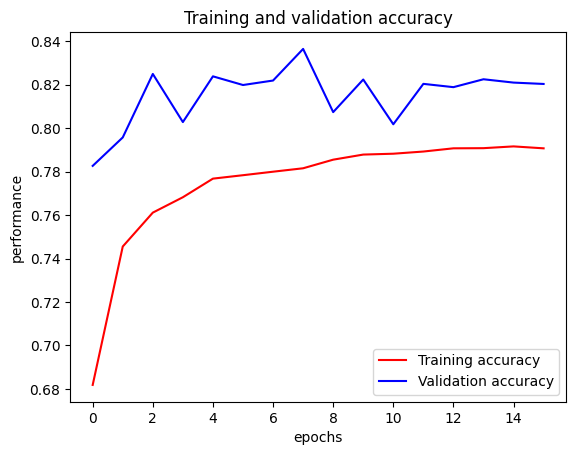

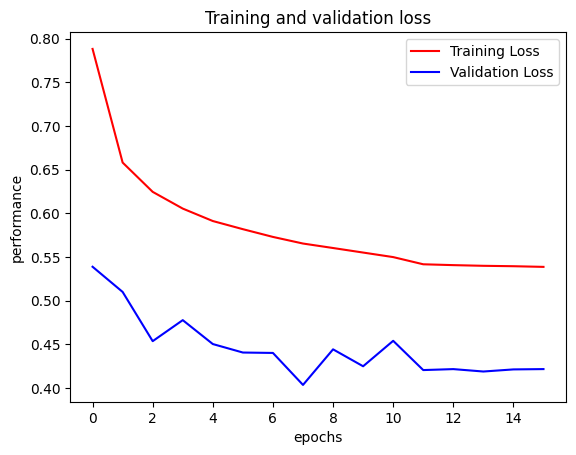

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("epochs")
plt.ylabel("performance")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("epochs")
plt.ylabel("performance")
plt.legend()

plt.show()

### 4.2 Tensorboard

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit